In [1]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_absolute_error
import scipy.stats
import numpy as np
import statsmodels.api as sm

# 使用allRNA,直接使用整个数据集进行训练

In [3]:
# 读取数据
mirna = pd.read_csv('./all_ori_new.csv',index_col=0)
# 删除空值行
mirna = mirna.dropna(subset=['HAMD'])

# 提取特征和标签
X = mirna.drop(columns=['HAMD'])
y = mirna['HAMD']
y


allRNA
test.Control_1           5.0
test.Control_10          4.0
test.Control_11          5.0
test.Control_12          4.0
test.Control_13          7.0
                        ... 
train.Depression_199    23.0
train.Depression_200    31.0
train.Depression_201    21.0
train.Depression_202    17.0
train.Depression_203     8.0
Name: HAMD, Length: 580, dtype: float64

In [4]:
mirna

,HAMD,hsa-let-7a-1_hsa-let-7a-3p,hsa-let-7a-1_hsa-let-7a-5p,hsa-let-7a-2_hsa-let-7a-5p,hsa-let-7a-3_hsa-let-7a-3p,hsa-let-7a-3_hsa-let-7a-5p,hsa-let-7b_hsa-let-7b-3p,hsa-let-7b_hsa-let-7b-5p,hsa-let-7c_hsa-let-7c-5p,hsa-let-7d_hsa-let-7d-3p,...,piR-hsa-376663,piR-hsa-3784255,piR-hsa-4360657,piR-hsa-4404178,piR-hsa-4419732,piR-hsa-4493515,piR-hsa-737914,piR-hsa-7572632,piR-hsa-788844,piR-hsa-789156
allRNA,,,,,,,,,,,,,,,,,,,,,
test.Control_1,5.0,4.636343,11.932248,11.931450,4.636343,11.931450,5.513216,14.822116,10.794625,9.237331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
test.Control_10,4.0,5.642016,11.510990,11.510514,5.642016,11.511823,4.577311,15.680377,11.050713,8.528478,...,0.000000,8.231833,8.815194,7.236623,12.871074,0.000000,7.236623,0.000000,7.236623,7.236623
test.Control_11,5.0,5.843266,12.198160,12.197301,5.843266,12.198160,5.101686,15.676319,11.149399,8.944256,...,0.000000,8.123240,9.342672,8.858133,15.418822,9.704748,0.000000,8.123240,7.540862,9.535040
test.Control_12,4.0,5.000036,11.509317,11.509071,5.000036,11.509225,4.702476,15.485785,10.862766,9.202785,...,0.000000,7.041156,8.618797,0.000000,11.674459,10.201311,0.000000,8.618797,0.000000,8.618797
test.Control_13,7.0,5.536349,12.352857,12.351838,5.536349,12.352275,4.611005,15.818532,11.493653,9.369764,...,0.000000,10.128330,7.137324,9.129619,14.326783,11.651051,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train.Depression_199,23.0,5.598311,12.438134,12.438845,5.597605,12.438434,4.995165,14.511007,10.927081,9.411388,...,-0.402225,4.325735,10.225863,3.461015,4.997622,11.109526,7.685589,5.715477,0.834392,6.621472
train.Depression_200,31.0,4.279953,11.531938,11.532336,4.277172,11.531897,5.826761,14.270540,10.297274,9.249851,...,-2.108927,4.325735,3.179230,2.313943,14.883292,9.295308,7.244516,6.527000,7.952148,7.086047
train.Depression_201,21.0,6.047102,12.133452,12.134058,6.047103,12.133638,5.839293,14.713968,10.589249,9.131661,...,-0.647795,4.325735,7.860617,0.934289,4.997622,3.342067,0.476291,6.395959,10.811165,8.212888


In [5]:
X

,hsa-let-7a-1_hsa-let-7a-3p,hsa-let-7a-1_hsa-let-7a-5p,hsa-let-7a-2_hsa-let-7a-5p,hsa-let-7a-3_hsa-let-7a-3p,hsa-let-7a-3_hsa-let-7a-5p,hsa-let-7b_hsa-let-7b-3p,hsa-let-7b_hsa-let-7b-5p,hsa-let-7c_hsa-let-7c-5p,hsa-let-7d_hsa-let-7d-3p,hsa-let-7d_hsa-let-7d-5p,...,piR-hsa-376663,piR-hsa-3784255,piR-hsa-4360657,piR-hsa-4404178,piR-hsa-4419732,piR-hsa-4493515,piR-hsa-737914,piR-hsa-7572632,piR-hsa-788844,piR-hsa-789156
allRNA,,,,,,,,,,,,,,,,,,,,,
test.Control_1,4.636343,11.932248,11.931450,4.636343,11.931450,5.513216,14.822116,10.794625,9.237331,9.921694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
test.Control_10,5.642016,11.510990,11.510514,5.642016,11.511823,4.577311,15.680377,11.050713,8.528478,9.391978,...,0.000000,8.231833,8.815194,7.236623,12.871074,0.000000,7.236623,0.000000,7.236623,7.236623
test.Control_11,5.843266,12.198160,12.197301,5.843266,12.198160,5.101686,15.676319,11.149399,8.944256,10.185719,...,0.000000,8.123240,9.342672,8.858133,15.418822,9.704748,0.000000,8.123240,7.540862,9.535040
test.Control_12,5.000036,11.509317,11.509071,5.000036,11.509225,4.702476,15.485785,10.862766,9.202785,9.430012,...,0.000000,7.041156,8.618797,0.000000,11.674459,10.201311,0.000000,8.618797,0.000000,8.618797
test.Control_13,5.536349,12.352857,12.351838,5.536349,12.352275,4.611005,15.818532,11.493653,9.369764,10.166986,...,0.000000,10.128330,7.137324,9.129619,14.326783,11.651051,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train.Depression_199,5.598311,12.438134,12.438845,5.597605,12.438434,4.995165,14.511007,10.927081,9.411388,10.493430,...,-0.402225,4.325735,10.225863,3.461015,4.997622,11.109526,7.685589,5.715477,0.834392,6.621472
train.Depression_200,4.279953,11.531938,11.532336,4.277172,11.531897,5.826761,14.270540,10.297274,9.249851,9.351579,...,-2.108927,4.325735,3.179230,2.313943,14.883292,9.295308,7.244516,6.527000,7.952148,7.086047
train.Depression_201,6.047102,12.133452,12.134058,6.047103,12.133638,5.839293,14.713968,10.589249,9.131661,9.586469,...,-0.647795,4.325735,7.860617,0.934289,4.997622,3.342067,0.476291,6.395959,10.811165,8.212888


In [6]:

import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# 设置 l1_ratio 和 alpha 的范围
ratios = np.arange(0.01, 1.01, 0.05)
alphas = np.concatenate((
    [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 0],
    np.arange(0.1, 1.0, 0.1),
    np.arange(1, 11, 1)
))

# 设置交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 记录总的模型数量
total_models = len(ratios) * len(alphas) * kf.get_n_splits(X)
progress = 0

# 初始化变量以记录最佳参数和误差
best_ratio = None
best_alpha = None
best_mse = float('inf')
best_r2 = float('-inf')

# 打开文件记录训练进度和结果
with open('elastic_net_cv_progress.txt', 'w') as f:

    # 开始手动交叉验证
    for ratio in ratios:
        for alpha in alphas:
            for fold, (train_index, val_index) in enumerate(kf.split(X)):
                X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
                y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

                # 创建和训练 ElasticNet 模型
                model = ElasticNet(alpha=alpha, l1_ratio=ratio, random_state=42, max_iter=10000)
                model.fit(X_train_fold, y_train_fold)

                # 预测和计算 MSE 和 R2
                y_val_pred = model.predict(X_val_fold)
                mse = mean_squared_error(y_val_fold, y_val_pred)
                r2 = r2_score(y_val_fold, y_val_pred)

                # 记录最佳参数和误差
                if mse < best_mse:
                    best_mse = mse
                    best_ratio = ratio
                    best_alpha = alpha
                    best_r2 = r2

                # 更新进度
                progress += 1
                progress_msg = (f"训练进度: 第 {progress} / {total_models} 个模型 - "
                                f"当前 l1_ratio: {ratio}, alpha: {alpha}, MSE: {mse}, R2: {r2}")
                print(progress_msg)
                f.write(progress_msg + '\n')

    # 输出最终结果
    result_msg = (f"最佳平均交叉验证误差(MSE): {best_mse}\n"
                  f"最佳 l1_ratio: {best_ratio}\n"
                  f"最佳 alpha: {best_alpha}\n"
                  f"最佳 R2: {best_r2}\n")
    print(result_msg)
    f.write(result_msg)


训练进度: 第 1 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-06, MSE: 148.56691510865335, R2: -0.678875873466017
训练进度: 第 2 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-06, MSE: 151.1465581496039, R2: -0.40086627309218814
训练进度: 第 3 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-06, MSE: 130.35562063526237, R2: -0.2692122068985632
训练进度: 第 4 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-06, MSE: 134.33237962482457, R2: -0.182585037992667
训练进度: 第 5 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-06, MSE: 153.7866138468699, R2: -0.8551712947708876
训练进度: 第 6 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-05, MSE: 148.53567645096228, R2: -0.6785228619716435
训练进度: 第 7 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-05, MSE: 151.12643500644083, R2: -0.400679766479594
训练进度: 第 8 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-05, MSE: 130.35607469174204, R2: -0.2692166278358714
训练进度: 第 9 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-05, MSE: 134.2222906659316, R2: -0.18161587809243573
训练进度: 第 10 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 1e-05, MS

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.461e+00, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 16 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.001, MSE: 135.22235404156402, R2: -0.528076069881583


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.144e+00, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 17 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.001, MSE: 108.5039227805576, R2: -0.005643051236629448


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.575e+00, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 18 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.001, MSE: 90.22181491462622, R2: 0.12155204156029864


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.731e+00, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 19 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.001, MSE: 104.9115327845057, R2: 0.0764191825504883


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.174e+00, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 20 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.001, MSE: 125.41486082657913, R2: -0.5129148364943406


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.682e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 21 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.01, MSE: 125.80369479552456, R2: -0.4216407995725191


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.199e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 22 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.01, MSE: 102.38652364534926, R2: 0.05105462175354547


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.100e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 23 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.01, MSE: 85.81139255912487, R2: 0.16449427806610506


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.879e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 24 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.01, MSE: 102.43893347049585, R2: 0.0981865253301335


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.303e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ret

训练进度: 第 25 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.01, MSE: 117.35589051503035, R2: -0.4156972047810692
训练进度: 第 26 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 27 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 28 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 29 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 30 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.868e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 31 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.1, MSE: 96.49258229699443, R2: -0.09041147060488663
训练进度: 第 32 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.1, MSE: 81.72646908914545, R2: 0.24253747113066415


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.820e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 33 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.1, MSE: 75.52365723989712, R2: 0.2646611844478406


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 34 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.1, MSE: 82.12655371469309, R2: 0.2770050384267213


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 35 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.1, MSE: 93.09911720958056, R2: -0.12308090733892918
训练进度: 第 36 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.2, MSE: 82.24948654659272, R2: 0.07054219664550776
训练进度: 第 37 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.2, MSE: 71.54579457579575, R2: 0.3368946548977242
训练进度: 第 38 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.2, MSE: 68.09102075979457, R2: 0.3370293178970388
训练进度: 第 39 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.2, MSE: 71.02466139662612, R2: 0.37473971554194385
训练进度: 第 40 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.2, MSE: 79.89531314993114, R2: 0.036200304858327814
训练进度: 第 41 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.30000000000000004, MSE: 73.87562734121933, R2: 0.16517073609805666
训练进度: 第 42 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.30000000000000004, MSE: 65.66301388886384, R2: 0.3914178220621669
训练进度: 第 43 / 2500 个模型 - 当前 l1_ratio: 0.01, alpha: 0.30000000000000004, MSE: 62.846380372096846, R2: 0.38809394839336664
训练进度: 第 44 / 2500 个模型 - 当

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.833e+00, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 141 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.001, MSE: 134.89451977028793, R2: -0.5243713887408445


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.757e+00, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 142 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.001, MSE: 107.16819907025776, R2: 0.0067367893554173275


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.065e+00, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 143 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.001, MSE: 88.83686059690773, R2: 0.13503669927953543


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.301e+00, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 144 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.001, MSE: 102.489159055597, R2: 0.09774436815528909


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.638e+00, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 145 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.001, MSE: 122.20860017907923, R2: -0.47423681005233753


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.602e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 146 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.01, MSE: 126.02036373179784, R2: -0.4240892602501385


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 147 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.01, MSE: 102.07283121752872, R2: 0.05396200613356705


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 148 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.01, MSE: 87.32123932987491, R2: 0.14979360046859502


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.210e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 149 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.01, MSE: 99.27764897698745, R2: 0.1260166564817028


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.499e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ret

训练进度: 第 150 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.01, MSE: 117.51287149244453, R2: -0.4175909105844484
训练进度: 第 151 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 152 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 153 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 154 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 155 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597
训练进度: 第 156 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.1, MSE: 93.12774285735382, R2: -0.05238720558485799
训练进度: 第 157 / 2500 个模型 - 当前 l1_ratio: 0.060000000000000005, alpha: 0.1, MSE: 77.31904551332919, R2: 0.2833866384169028
训练进度: 第 158 / 2500 个模型 - 当前 l1_r

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.024e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 266 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.001, MSE: 134.40364893868727, R2: -0.5188243179440939


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 267 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.001, MSE: 106.32287908821425, R2: 0.0145714385019996


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.235e+00, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 268 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.001, MSE: 88.30074376414188, R2: 0.14025662017864338


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 269 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.001, MSE: 100.93263943927538, R2: 0.1114470719616607


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.737e+00, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 270 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.001, MSE: 121.24504741670583, R2: -0.46261320133219086


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 271 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.01, MSE: 126.54785261400613, R2: -0.43005013220614163


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.394e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 272 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.01, MSE: 101.81225666503241, R2: 0.056377079997550594


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.776e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 273 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.01, MSE: 88.50213489316239, R2: 0.1382957681795638


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.432e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 274 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.01, MSE: 96.66279964432735, R2: 0.14903628664120228


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ret

训练进度: 第 275 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.01, MSE: 118.19172962815935, R2: -0.4257801677317177
训练进度: 第 276 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 277 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 278 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 279 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 280 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597
训练进度: 第 281 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.1, MSE: 91.52327483170883, R2: -0.034255963807151346
训练进度: 第 282 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.1, MSE: 73.97969501261292, R2: 0.3143366219809127
训练进度: 第 283 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.1, MSE: 72.75140051286306, R2: 0.29165336216492854
训练进度: 第 284 / 2500 个模型 - 当前 l1_ratio: 0.11, alpha: 0.1,

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 391 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.001, MSE: 133.94851866845087, R2: -0.5136811322662789


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.209e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 392 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.001, MSE: 105.01722614215878, R2: 0.026672575298526513


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.043e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 393 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.001, MSE: 88.52330251526912, R2: 0.1380896688626494


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 394 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.001, MSE: 100.49728289954537, R2: 0.11527970063625781


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 395 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.001, MSE: 121.18540946259557, R2: -0.46189377187226155


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.843e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 396 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.01, MSE: 126.92070263615123, R2: -0.43426351246070816


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.095e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 397 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.01, MSE: 101.40533464581453, R2: 0.06014854088610533


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 398 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.01, MSE: 88.7104499001798, R2: 0.13626750159237588


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.555e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 399 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.01, MSE: 94.66918379233084, R2: 0.16658693440505967


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ret

训练进度: 第 400 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.01, MSE: 118.01234238493757, R2: -0.4236161688247353
训练进度: 第 401 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 402 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 403 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 404 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 405 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597
训练进度: 第 406 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.1, MSE: 88.7040014023441, R2: -0.0023968507751370716
训练进度: 第 407 / 2500 个模型 - 当前 l1_ratio: 0.16000000000000003, alpha: 0.1, MSE: 70.8531154958704, R2: 0.3433145877961201
训练进度: 第 408 / 2500 个模型 - 当前 l1_ratio: 0.

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 516 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.001, MSE: 133.8615076097079, R2: -0.51269786646217


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 517 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.001, MSE: 104.66609500491101, R2: 0.02992695153854663


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 518 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.001, MSE: 89.03056563922824, R2: 0.13315068314112188


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.297e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 519 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.001, MSE: 99.85551812601463, R2: 0.1209294287301681


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 520 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.001, MSE: 121.8307900490354, R2: -0.46967917990106267


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 521 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.01, MSE: 127.42868572271075, R2: -0.4400039597704599


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 522 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.01, MSE: 101.0518073238911, R2: 0.06342512559939373


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 523 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.01, MSE: 88.27888174112594, R2: 0.14046948055508202


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.356e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 524 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.01, MSE: 93.34153296637602, R2: 0.17827480896544334


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ret

训练进度: 第 525 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.01, MSE: 118.9006390637974, R2: -0.43433194218523075
训练进度: 第 526 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 527 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 528 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 529 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 530 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597
训练进度: 第 531 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.1, MSE: 85.7887081705922, R2: 0.030547331092592556
训练进度: 第 532 / 2500 个模型 - 当前 l1_ratio: 0.21000000000000002, alpha: 0.1, MSE: 68.24189969400301, R2: 0.3675160264089715
训练进度: 第 533 / 2500 个模型 - 当前 l1_ratio: 0.2

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 641 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.001, MSE: 134.7875955516391, R2: -0.5231630948831747


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 642 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.001, MSE: 105.31957146471687, R2: 0.023870358890928367


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 643 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.001, MSE: 90.15272982288596, R2: 0.12222469105039457


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 644 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.001, MSE: 98.84361436153931, R2: 0.12983764769494133


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 645 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.001, MSE: 123.6295477950193, R2: -0.49137810188863495


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.339e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 646 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.01, MSE: 127.60536842400099, R2: -0.4420005572244625


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 647 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.01, MSE: 100.69727980642948, R2: 0.06671098038944134


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 648 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.01, MSE: 87.90141753792463, R2: 0.14414467439816792


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 649 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.01, MSE: 91.72555618034868, R2: 0.19250093950996816


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ret

训练进度: 第 650 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.01, MSE: 120.33986151701033, R2: -0.4516936885375431
训练进度: 第 651 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 652 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 653 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 654 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 655 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597
训练进度: 第 656 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.1, MSE: 82.77350343921697, R2: 0.06462055980144954
训练进度: 第 657 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.1, MSE: 66.00046709032756, R2: 0.388290216548255
训练进度: 第 658 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.1, MSE: 69.97361557941646, R2: 0.31869936546335187
训练进度: 第 659 / 2500 个模型 - 当前 l1_ratio: 0.26, alpha: 0.1, MS

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 766 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.001, MSE: 135.59865901773776, R2: -0.5323284927383225


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 767 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.001, MSE: 108.18760839766657, R2: -0.0027113658836130927


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.184e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 768 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.001, MSE: 91.38065192335577, R2: 0.11026898318416067


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 769 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.001, MSE: 96.66679452547984, R2: 0.14900111800432791


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 770 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.001, MSE: 125.70774395750205, R2: -0.5164479683035359


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 771 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.01, MSE: 126.68261147881061, R2: -0.43157297063009636


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 772 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.01, MSE: 100.14573679394053, R2: 0.0718228268900456


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 773 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.01, MSE: 88.33136131308919, R2: 0.1399585113078493


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 774 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.01, MSE: 90.12372490494367, R2: 0.20660254111170573


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.342e+00, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ret

训练进度: 第 775 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.01, MSE: 121.4993139947825, R2: -0.4656804907735017
训练进度: 第 776 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 777 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 778 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 779 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 780 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597
训练进度: 第 781 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.1, MSE: 80.27118726056447, R2: 0.09289790713043533
训练进度: 第 782 / 2500 个模型 - 当前 l1_ratio: 0.31000000000000005, alpha: 0.1, MSE: 65.04716194612962, R2: 0.39712570073539966
训练进度: 第 783 / 2500 个模型 - 当前 l1_ratio: 0.3

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.407e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 891 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.001, MSE: 135.41510678599857, R2: -0.5302542663659002


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 892 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.001, MSE: 110.5093068702283, R2: -0.024229481322816104


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 893 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.001, MSE: 91.8601267700002, R2: 0.10560055902802334


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 894 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.001, MSE: 95.37092430599965, R2: 0.16040921437705336


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 895 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.001, MSE: 127.32623334721019, R2: -0.5359722622688583


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 896 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.01, MSE: 125.84341724040992, R2: -0.4220896818442168


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.172e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 897 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.01, MSE: 99.18489347404581, R2: 0.08072817688309131


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.840e+00, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 898 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.01, MSE: 88.75135613315491, R2: 0.13586921657806472


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.625e+00, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 899 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.01, MSE: 88.35330964343115, R2: 0.22218825920250396


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.795e+00, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ret

训练进度: 第 900 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.01, MSE: 121.61000975959931, R2: -0.46701584500365145
训练进度: 第 901 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 902 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 903 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 904 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 905 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597
训练进度: 第 906 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.1, MSE: 77.8486394737238, R2: 0.12027383419111926
训练进度: 第 907 / 2500 个模型 - 当前 l1_ratio: 0.36000000000000004, alpha: 0.1, MSE: 64.56357556314137, R2: 0.401607707222007
训练进度: 第 908 / 2500 个模型 - 当前 l1_ratio: 0.36

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1016 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.001, MSE: 135.33004262414568, R2: -0.5292930014104624


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1017 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.001, MSE: 111.96113611669595, R2: -0.03768541872929232


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.276e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1018 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.001, MSE: 92.34068532679562, R2: 0.1009215832888728


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1019 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.001, MSE: 94.72356855507395, R2: 0.16610816222150715


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1020 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.001, MSE: 127.85639844590246, R2: -0.5423677933751132


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.656e+00, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1021 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.01, MSE: 124.70782263797747, R2: -0.4092569298235684


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.922e+00, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1022 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.01, MSE: 97.91704503857375, R2: 0.09247893147776454
训练进度: 第 1023 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.01, MSE: 88.89309584301036, R2: 0.1344891627754431


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.209e+00, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1024 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.01, MSE: 87.32467149234039, R2: 0.23124379808587514
训练进度: 第 1025 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.01, MSE: 122.01220493951033, R2: -0.4718676388887104
训练进度: 第 1026 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 1027 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 1028 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 1029 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 1030 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597


d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 1031 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.1, MSE: 75.99801377422527, R2: 0.1411867732222083
训练进度: 第 1032 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.1, MSE: 64.33667705163333, R2: 0.40371066263215816
训练进度: 第 1033 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.1, MSE: 66.64613893193504, R2: 0.3510974619824896
训练进度: 第 1034 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.1, MSE: 60.31567386534063, R2: 0.4690154848085808
训练进度: 第 1035 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.1, MSE: 81.90966055634588, R2: 0.01190066399493106
训练进度: 第 1036 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.2, MSE: 62.05799089724549, R2: 0.29871557474985433
训练进度: 第 1037 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.2, MSE: 55.649403423285904, R2: 0.4842266120527835
训练进度: 第 1038 / 2500 个模型 - 当前 l1_ratio: 0.41000000000000003, alpha: 0.2, MSE: 55.034043674273605, R2: 0.46415904672175157
训练进度: 第 1039 / 2500 个模型 - 当前 l1_ratio: 0.4

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1141 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.001, MSE: 135.36543225902352, R2: -0.529692920895388


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1142 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.001, MSE: 113.23109588608834, R2: -0.04945574172510159


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1143 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.001, MSE: 92.83158271601366, R2: 0.09614194313454849


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1144 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.001, MSE: 94.34650154223341, R2: 0.16942764341398808


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1145 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.001, MSE: 128.51253023060377, R2: -0.5502828961406678


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.733e+00, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1146 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.01, MSE: 123.94696672735502, R2: -0.4006589009111834


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.031e+00, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1147 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.01, MSE: 97.1777895244103, R2: 0.09933054708626521
训练进度: 第 1148 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.01, MSE: 89.03684607344827, R2: 0.13308953346657904


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.489e+00, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1149 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.01, MSE: 86.89681298385317, R2: 0.23501041840428216
训练进度: 第 1150 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.01, MSE: 122.10378756770706, R2: -0.47297242596139677
训练进度: 第 1151 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 1152 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 1153 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 1154 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 1155 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597


d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 1156 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.1, MSE: 74.93886807675709, R2: 0.15315561673399702
训练进度: 第 1157 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.1, MSE: 64.1927149636465, R2: 0.4050449413357795
训练进度: 第 1158 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.1, MSE: 65.65267884687535, R2: 0.36077032197026326
训练进度: 第 1159 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.1, MSE: 59.70939697793618, R2: 0.4743527979562202
训练进度: 第 1160 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.1, MSE: 80.45685954591784, R2: 0.029426212312445577
训练进度: 第 1161 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.2, MSE: 61.058652235290566, R2: 0.3100085706887611
训练进度: 第 1162 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.2, MSE: 54.98333322913136, R2: 0.4903999267608796
训练进度: 第 1163 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.2, MSE: 54.06166573892328, R2: 0.4736266395976939
训练进度: 第 1164 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.2, MSE: 51.16775492646128, R2: 0.5495485036987582
训练进度: 第 1165 / 2500 个模型 - 当前 l1_ratio: 0.46, alpha: 0.2, MSE

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1266 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.001, MSE: 135.29117349701497, R2: -0.5288537620299134


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1267 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.001, MSE: 113.85822000200002, R2: -0.05526809388037779


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1268 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.001, MSE: 92.78951751402715, R2: 0.0965515124924845


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1269 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.001, MSE: 93.7048628043603, R2: 0.17507626196243087


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1270 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.001, MSE: 130.23197785106683, R2: -0.5710250777165067
训练进度: 第 1271 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.01, MSE: 123.68368826502122, R2: -0.3976837307120029
训练进度: 第 1272 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.01, MSE: 96.50835764896028, R2: 0.10553501874563687
训练进度: 第 1273 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.01, MSE: 88.86587667826268, R2: 0.13475418315577636


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.148e+00, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1274 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.01, MSE: 86.39147746721919, R2: 0.23945910175826335
训练进度: 第 1275 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.01, MSE: 121.74838751059013, R2: -0.4686851348400789
训练进度: 第 1276 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 1277 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 1278 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 1279 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.0, MSE: 134.34082047701807, R2: -0.18265934640244752
训练进度: 第 1280 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.0, MSE: 153.78846938118656, R2: -0.8551936786046597


d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 1281 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.1, MSE: 74.07048544406169, R2: 0.16296874807554085
训练进度: 第 1282 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.1, MSE: 63.84332494642695, R2: 0.4082831804149222
训练进度: 第 1283 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.1, MSE: 64.61101603281575, R2: 0.37091250956933863
训练进度: 第 1284 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.1, MSE: 59.16312282698463, R2: 0.47916188150972905
训练进度: 第 1285 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.1, MSE: 79.04650378592518, R2: 0.046439731603262535
训练进度: 第 1286 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.2, MSE: 59.97428755387021, R2: 0.32226240055622435
训练进度: 第 1287 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.2, MSE: 54.681395074900486, R2: 0.4931983694247416
训练进度: 第 1288 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.2, MSE: 53.424437635280555, R2: 0.4798310340363898
训练进度: 第 1289 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.2, MSE: 50.04633921600601, R2: 0.5594208028738206
训练进度: 第 1290 / 2500 个模型 - 当前 l1_ratio: 0.51, alpha: 0.2,

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1391 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.001, MSE: 135.9825810102072, R2: -0.5366669914543962


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1392 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.001, MSE: 114.71844467074152, R2: -0.06324088360496494


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1393 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.001, MSE: 92.5435117869789, R2: 0.09894675613610338


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1394 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.001, MSE: 92.8924661366866, R2: 0.1822281351503341


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1395 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.001, MSE: 132.5528041961754, R2: -0.5990218604526207
训练进度: 第 1396 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.01, MSE: 123.51823465569053, R2: -0.3958140272677335
训练进度: 第 1397 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.01, MSE: 95.83008975141371, R2: 0.1118213849945704
训练进度: 第 1398 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.01, MSE: 88.46447320652523, R2: 0.13866246255130876
训练进度: 第 1399 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.01, MSE: 86.26202334623002, R2: 0.2405987414119034
训练进度: 第 1400 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.01, MSE: 121.60522727883671, R2: -0.4669581525894251
训练进度: 第 1401 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 1402 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 1403 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 1404 / 2500 个模型 - 当前 l1_ratio: 0.56, 

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 1406 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.1, MSE: 72.97598592137497, R2: 0.17533710640629663
训练进度: 第 1407 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.1, MSE: 63.40972042504948, R2: 0.4123019417899365
训练进度: 第 1408 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.1, MSE: 63.69751166071343, R2: 0.3798068778710446
训练进度: 第 1409 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.1, MSE: 58.53188904967115, R2: 0.4847189007675682
训练进度: 第 1410 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.1, MSE: 77.9392193846678, R2: 0.05979721561943119
训练进度: 第 1411 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.2, MSE: 58.66525194845126, R2: 0.33705511731849
训练进度: 第 1412 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.2, MSE: 54.701650236992315, R2: 0.493010639225802
训练进度: 第 1413 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.2, MSE: 52.73111797427222, R2: 0.4865815659486018
训练进度: 第 1414 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.2, MSE: 49.172586989702125, R2: 0.5671128151245199
训练进度: 第 1415 / 2500 个模型 - 当前 l1_ratio: 0.56, alpha: 0.2, MSE: 61

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1516 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.001, MSE: 136.69428119340958, R2: -0.5447095375747486


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1517 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.001, MSE: 115.63880248459144, R2: -0.07177100322120555


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.418e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1518 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.001, MSE: 92.42295625557416, R2: 0.10012054942036952


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.555e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1519 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.001, MSE: 92.23652502436283, R2: 0.1880026635805221


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1520 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.001, MSE: 133.91604548254531, R2: -0.6154670245605856
训练进度: 第 1521 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.01, MSE: 122.29815566811138, R2: -0.3820265620405565
训练进度: 第 1522 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.01, MSE: 95.8665032925283, R2: 0.11148389466560915
训练进度: 第 1523 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.01, MSE: 88.14089420031446, R2: 0.1418130012283324
训练进度: 第 1524 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.01, MSE: 86.2055593264719, R2: 0.241095818178781
训练进度: 第 1525 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.01, MSE: 121.22354428132137, R2: -0.4623538029455889
训练进度: 第 1526 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 1527 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 1528 / 2500 个模型 - 当前 l1_ratio: 0.6

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 1531 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.1, MSE: 71.8859808062348, R2: 0.18765467582223982
训练进度: 第 1532 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.1, MSE: 62.56810517094949, R2: 0.4201022545381874
训练进度: 第 1533 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.1, MSE: 62.937298045834396, R2: 0.3872087251803731
训练进度: 第 1534 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.1, MSE: 58.11509402925806, R2: 0.4883881244977438
训练进度: 第 1535 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.1, MSE: 77.0078421822688, R2: 0.07103268148523867
训练进度: 第 1536 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.2, MSE: 57.49760295506316, R2: 0.350250099002282
训练进度: 第 1537 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.2, MSE: 54.576124202769954, R2: 0.49417404770754236
训练进度: 第 1538 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000001, alpha: 0.2, MSE: 52.06082518935944, R2: 0.4931078958503077
训练进度: 第 1539 / 2500 个模型 - 当前 l1_ratio: 0.6100000000000

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1641 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.001, MSE: 137.35739777609822, R2: -0.5522030662056487


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1642 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.001, MSE: 116.76038100957803, R2: -0.0821660896030143


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1643 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.001, MSE: 92.55336356001558, R2: 0.09885083399222627


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1644 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.001, MSE: 91.53804191391981, R2: 0.19415170730331965


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1645 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.001, MSE: 134.70980906046086, R2: -0.6250424184635286
训练进度: 第 1646 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.01, MSE: 121.18457998736167, R2: -0.3694426341699275
训练进度: 第 1647 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.01, MSE: 95.60555196414391, R2: 0.11390246058816533
训练进度: 第 1648 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.01, MSE: 87.78759388800711, R2: 0.14525292247527455
训练进度: 第 1649 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.01, MSE: 85.41115964100922, R2: 0.24808925628237155
训练进度: 第 1650 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.01, MSE: 120.57425669323598, R2: -0.45452126365405854
训练进度: 第 1651 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 1652 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 1653 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 1654 / 2500 个模型 - 当前 l1_ratio: 0.

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 1656 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.1, MSE: 70.65750506171341, R2: 0.2015370283440433
训练进度: 第 1657 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.1, MSE: 61.888452100736295, R2: 0.4264014589337174
训练进度: 第 1658 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.1, MSE: 62.26702570418289, R2: 0.3937348560355274
训练进度: 第 1659 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.1, MSE: 57.47154576779482, R2: 0.49405355339402446
训练进度: 第 1660 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.1, MSE: 76.02183374202887, R2: 0.08292717938059102
训练进度: 第 1661 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.2, MSE: 56.39108822630176, R2: 0.3627542348012496
训练进度: 第 1662 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.2, MSE: 54.31202021996109, R2: 0.4966218332650544
训练进度: 第 1663 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.2, MSE: 51.5578057617525, R2: 0.49800556266908047
训练进度: 第 1664 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.2, MSE: 48.24531778886407, R2: 0.575275960050301
训练进度: 第 1665 / 2500 个模型 - 当前 l1_ratio: 0.66, alpha: 0.2, MSE: 

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1766 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.001, MSE: 138.2633124727196, R2: -0.562440327485952


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1767 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.001, MSE: 117.35529679904371, R2: -0.0876799264709871


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1768 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.001, MSE: 91.9787362706695, R2: 0.10444571334227537


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1769 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.001, MSE: 90.79414729071726, R2: 0.20070052787583903


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1770 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.001, MSE: 135.41969513635738, R2: -0.633605974403918
训练进度: 第 1771 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.01, MSE: 120.22123510200038, R2: -0.3585563848008997
训练进度: 第 1772 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.01, MSE: 95.37683251407287, R2: 0.11602229293848298
训练进度: 第 1773 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.01, MSE: 87.36109155040317, R2: 0.14940557788452857
训练进度: 第 1774 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.01, MSE: 84.44782241919577, R2: 0.25656992332809614
训练进度: 第 1775 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.01, MSE: 120.34980878673437, R2: -0.45181368525762
训练进度: 第 1776 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 1777 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 1778 / 2500 个模型 - 当前 l1_ratio: 0

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 1781 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.1, MSE: 69.41580225734845, R2: 0.2155688528504538
训练进度: 第 1782 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.1, MSE: 61.21954344829554, R2: 0.43260108122386776
训练进度: 第 1783 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.1, MSE: 61.49516406249356, R2: 0.4012501147784546
训练进度: 第 1784 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.1, MSE: 56.86219907479141, R2: 0.4994178913452222
训练进度: 第 1785 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.1, MSE: 75.07459079855401, R2: 0.09435403815555965
训练进度: 第 1786 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.2, MSE: 55.377132052143395, R2: 0.3742124154890657
训练进度: 第 1787 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.2, MSE: 53.92915235591325, R2: 0.5001703538821405
训练进度: 第 1788 / 2500 个模型 - 当前 l1_ratio: 0.7100000000000001, alpha: 0.2, MSE: 51.13243338208431, R2: 0.5021472162020952
训练进度: 第 1789 / 2500 个模型 - 当前 l1_ratio: 0.710000000000

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1891 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.001, MSE: 138.6074065339661, R2: -0.5663287518852012


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1892 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.001, MSE: 117.39412410829466, R2: -0.08803978824138059


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1893 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.001, MSE: 91.70561565581983, R2: 0.10710496206997533


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1894 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.001, MSE: 90.34830359900788, R2: 0.20462547940704445


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 1895 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.001, MSE: 136.1815123767409, R2: -0.6427959906274909
训练进度: 第 1896 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.01, MSE: 119.0296762610283, R2: -0.3450912106168622
训练进度: 第 1897 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.01, MSE: 95.35239321322523, R2: 0.11624880284194727
训练进度: 第 1898 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.01, MSE: 86.78962890641166, R2: 0.15496964455082118
训练进度: 第 1899 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.01, MSE: 83.38895131793073, R2: 0.265891615722857
训练进度: 第 1900 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.01, MSE: 121.0504663969119, R2: -0.4602659156133675
训练进度: 第 1901 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 1902 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 1903 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 1904 / 2500 个模型 - 当前 l1_ratio: 0.76, al

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 1906 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.1, MSE: 68.1320745120813, R2: 0.23007557891427322
训练进度: 第 1907 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.1, MSE: 60.614263434478474, R2: 0.43821097646404805
训练进度: 第 1908 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.1, MSE: 60.877870898173974, R2: 0.4072604119606654
训练进度: 第 1909 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.1, MSE: 56.28488895635759, R2: 0.5045001977128185
训练进度: 第 1910 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.1, MSE: 73.99373202045838, R2: 0.10739274242679608
训练进度: 第 1911 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.2, MSE: 54.615122730305174, R2: 0.38282347848956466
训练进度: 第 1912 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.2, MSE: 53.62321855118655, R2: 0.5030058292914861
训练进度: 第 1913 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.2, MSE: 50.74984028444268, R2: 0.5058723477110815
训练进度: 第 1914 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.2, MSE: 47.384862807556146, R2: 0.5828509110010915
训练进度: 第 1915 / 2500 个模型 - 当前 l1_ratio: 0.76, alpha: 0.2, 

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2016 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.001, MSE: 138.61930718067148, R2: -0.5664632347787695


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.295e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2017 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.001, MSE: 117.30469530408816, R2: -0.08721093843368677


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.359e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2018 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.001, MSE: 91.61346702057041, R2: 0.10800217058417405


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2019 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.001, MSE: 90.76109039205082, R2: 0.2009915418061704


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2020 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.001, MSE: 137.08155665849313, R2: -0.6536534786348154
训练进度: 第 2021 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.01, MSE: 118.01688266479283, R2: -0.3336461676052531
训练进度: 第 2022 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.01, MSE: 94.84972686977984, R2: 0.12090764744795035
训练进度: 第 2023 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.01, MSE: 85.88522817629263, R2: 0.16377537491366323
训练进度: 第 2024 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.01, MSE: 82.66768781380122, R2: 0.27224120493445236
训练进度: 第 2025 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.01, MSE: 121.509963981568, R2: -0.4658089645676762
训练进度: 第 2026 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 2027 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 2028 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 2029 / 2500 个模型 - 当前 l1_ratio: 0.81,

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 2031 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.1, MSE: 66.89954148190867, R2: 0.24400378066830064
训练进度: 第 2032 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.1, MSE: 60.12300711269869, R2: 0.4427640699717643
训练进度: 第 2033 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.1, MSE: 60.28666853782723, R2: 0.41301667508796747
训练进度: 第 2034 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.1, MSE: 55.555626915590366, R2: 0.5109202014423433
训练进度: 第 2035 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.1, MSE: 72.95069901244237, R2: 0.11997514376568352
训练进度: 第 2036 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.2, MSE: 53.94336855554664, R2: 0.3904146159650743
训练进度: 第 2037 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.2, MSE: 53.34247549162431, R2: 0.5056078302127123
训练进度: 第 2038 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.2, MSE: 50.37664811139009, R2: 0.5095059467783796
训练进度: 第 2039 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.2, MSE: 47.3370472813342, R2: 0.5832718514031878
训练进度: 第 2040 / 2500 个模型 - 当前 l1_ratio: 0.81, alpha: 0.2, MSE:

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.561e+00, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2137 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.0001, MSE: 115.68758664243678, R2: -0.07222314769755633
训练进度: 第 2138 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.0001, MSE: 124.50227864374953, R2: -0.2122209312590806
训练进度: 第 2139 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.0001, MSE: 108.95848728932909, R2: 0.04079212182091918
训练进度: 第 2140 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.0001, MSE: 147.52008495443886, R2: -0.7795763894128285


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2141 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.001, MSE: 138.18592279608583, R2: -0.5615657878156577


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.423e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2142 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.001, MSE: 116.91576002138557, R2: -0.0836061833759214


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2143 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.001, MSE: 91.44287007583807, R2: 0.10966319389608559


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.396e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2144 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.001, MSE: 91.09620557213722, R2: 0.19804138042973052


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2145 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.001, MSE: 138.34617192184785, R2: -0.668908889211973
训练进度: 第 2146 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.01, MSE: 117.5250188287775, R2: -0.3280878753925309
训练进度: 第 2147 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.01, MSE: 94.01733931086676, R2: 0.12862243547685615
训练进度: 第 2148 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.01, MSE: 85.5532181003812, R2: 0.16700800300523722
训练进度: 第 2149 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.01, MSE: 82.55855185943537, R2: 0.2732019751307414
训练进度: 第 2150 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.01, MSE: 121.65021515846998, R2: -0.4675008540692256
训练进度: 第 2151 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 2152 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 2153 / 2500 个模型 - 当前 l1_ratio: 0.

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 2156 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.1, MSE: 65.7569110516944, R2: 0.25691604084528463
训练进度: 第 2157 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.1, MSE: 59.68910600994187, R2: 0.4467855801414363
训练进度: 第 2158 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.1, MSE: 59.67752359976067, R2: 0.41894763677106817
训练进度: 第 2159 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.1, MSE: 54.806901749000886, R2: 0.5175115473415985
训练进度: 第 2160 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.1, MSE: 71.95587317714919, R2: 0.13197600838430423
训练进度: 第 2161 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.2, MSE: 53.331294331079654, R2: 0.39733134199035747
训练进度: 第 2162 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.2, MSE: 52.97878356433691, R2: 0.5089786231766416
训练进度: 第 2163 / 2500 个模型 - 当前 l1_ratio: 0.8600000000000001, alpha: 0.2, MSE: 49.94113466592238, R2: 0.5137463391647018
训练进度: 第 2164 / 2500 个模型 - 当前 l1_ratio: 0.8600000000

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.704e+00, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2262 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.0001, MSE: 115.71804984023458, R2: -0.07250548867103213
训练进度: 第 2263 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.0001, MSE: 123.50194986279884, R2: -0.20248119396576492
训练进度: 第 2264 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.0001, MSE: 107.55405988377777, R2: 0.0531558932466204
训练进度: 第 2265 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.0001, MSE: 146.8999078824556, R2: -0.7720950184869819


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2266 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.001, MSE: 137.40226983832363, R2: -0.552710141570361


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.581e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2267 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.001, MSE: 116.79376075661713, R2: -0.08247546192616806


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.417e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2268 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.001, MSE: 91.20867520943514, R2: 0.11194344066859163


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2269 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.001, MSE: 90.95322155529047, R2: 0.1993001295077066


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2270 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.001, MSE: 139.37239444731466, R2: -0.6812885009588641
训练进度: 第 2271 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.01, MSE: 117.326610314557, R2: -0.32584576605498805
训练进度: 第 2272 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.01, MSE: 93.33601181929431, R2: 0.13493715885236057
训练进度: 第 2273 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.01, MSE: 85.3443070450023, R2: 0.16904207303881758
训练进度: 第 2274 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.01, MSE: 82.8358755002624, R2: 0.2707605772396324
训练进度: 第 2275 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.01, MSE: 121.40610219971877, R2: -0.4645560506014301
训练进度: 第 2276 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 2277 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 2278 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.0, MSE: 130.35765965170268, R2: -0.26923205985575427
训练进度: 第 2279 / 2500 个模型 - 当前 l1_ratio: 0.91, a

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 2281 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.1, MSE: 64.59619921888948, R2: 0.270032629358397
训练进度: 第 2282 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.1, MSE: 59.502591447445006, R2: 0.4485142464322279
训练进度: 第 2283 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.1, MSE: 59.14822862938393, R2: 0.42410113636071634
训练进度: 第 2284 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.1, MSE: 54.1810092473491, R2: 0.523021545079392
训练进度: 第 2285 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.1, MSE: 70.9934135228361, R2: 0.14358643063363385
训练进度: 第 2286 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.2, MSE: 52.966312297442634, R2: 0.4014558102817911
训练进度: 第 2287 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.2, MSE: 52.58189401597717, R2: 0.5126571004720997
训练进度: 第 2288 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.2, MSE: 49.47097784816165, R2: 0.5183240379961787
训练进度: 第 2289 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.2, MSE: 47.36201550610678, R2: 0.5830520455073661
训练进度: 第 2290 / 2500 个模型 - 当前 l1_ratio: 0.91, alpha: 0.2, MSE: 55

d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.841e+00, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2387 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.0001, MSE: 115.85573599130915, R2: -0.07378160033161851
训练进度: 第 2388 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.0001, MSE: 121.95988384360696, R2: -0.18746681249250186
训练进度: 第 2389 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.0001, MSE: 104.23388031661746, R2: 0.08238484527247403
训练进度: 第 2390 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.0001, MSE: 146.82374956517617, R2: -0.7711762992269589


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e+01, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2391 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.001, MSE: 136.60383958265518, R2: -0.5436875049227148


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+01, tolerance: 4.541e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2392 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.001, MSE: 116.7014530346769, R2: -0.08161992954756081


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e+01, tolerance: 4.577e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2393 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.001, MSE: 91.53082987957383, R2: 0.10880677009116047


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+01, tolerance: 4.465e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2394 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.001, MSE: 90.76792333332105, R2: 0.20093138851971604


d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e+01, tolerance: 4.838e+00
  model = cd_fast.enet_coordinate_descent(


训练进度: 第 2395 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.001, MSE: 139.55470826941936, R2: -0.6834878040122847
训练进度: 第 2396 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.01, MSE: 117.22622416246723, R2: -0.32471135541820284
训练进度: 第 2397 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.01, MSE: 92.89490910859885, R2: 0.1390254154289423
训练进度: 第 2398 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.01, MSE: 84.95264274444732, R2: 0.17285552664249215
训练进度: 第 2399 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.01, MSE: 82.11278632514951, R2: 0.2771262386089254
训练进度: 第 2400 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.01, MSE: 121.15606245759214, R2: -0.4615397506742651
训练进度: 第 2401 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.0, MSE: 148.5720329584234, R2: -0.6789337075705797
训练进度: 第 2402 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.0, MSE: 151.1600708181816, R2: -0.40099151207812134
训练进度: 第 2403 / 2500 个模型 - 当前 l1_ratio:

d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\biosoft\win_conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\win_conda\Lib\site-packages\sklearn\base.py:1151: UserWar

训练进度: 第 2406 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.1, MSE: 63.419308297171696, R2: 0.2833320491701913
训练进度: 第 2407 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.1, MSE: 59.54900702589601, R2: 0.4480840545760977
训练进度: 第 2408 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.1, MSE: 58.64803597709464, R2: 0.4289712801795461
训练进度: 第 2409 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.1, MSE: 53.49652377634706, R2: 0.5290473616322672
训练进度: 第 2410 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.1, MSE: 70.19253350126186, R2: 0.15324767220345892
训练进度: 第 2411 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.2, MSE: 52.78501314548886, R2: 0.4035045757951118
训练进度: 第 2412 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.2, MSE: 52.36243899709273, R2: 0.5146910676241119
训练进度: 第 2413 / 2500 个模型 - 当前 l1_ratio: 0.9600000000000001, alpha: 0.2, MSE: 49.08429959987332, R2: 0.522088944721934
训练进度: 第 2414 / 2500 个模型 - 当前 l1_ratio: 0.96000000000000

In [7]:
print(best_ratio)
print(best_alpha)
print(best_r2)
print(best_mse)

0.01
8.0
0.6694208881002044
33.95243527168167


In [8]:
result_msg = (f"最佳平均交叉验证误差(MSE): {best_mse}\n"
                  f"最佳 l1_ratio: {best_ratio}\n"
                  f"最佳 alpha: {best_alpha}\n"
                  f"最佳 R2: {best_r2}\n")
print(result_msg)


最佳平均交叉验证误差(MSE): 33.95243527168167
最佳 l1_ratio: 0.01
最佳 alpha: 8.0
最佳 R2: 0.6694208881002044



In [9]:
import concurrent.futures

X_array = X.to_numpy()
y_array = y.to_numpy()

num_bootstrap = 100
selected_features = np.zeros((X.shape[1], num_bootstrap))

# 定义一个函数，用于每个 Bootstrap 迭代
def bootstrap_iteration(i):
    bootstrap_indices = np.random.choice(range(X_array.shape[0]), size=int(0.8 * X_array.shape[0]), replace=True)
    X_bootstrap = X_array[bootstrap_indices]
    y_bootstrap = y_array[bootstrap_indices]
    
    # 使用 Elastic Net 模型拟合数据
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio, random_state=42)
    elastic_net.fit(X_bootstrap, y_bootstrap)
    
    return elastic_net.coef_ != 0

# 使用多线程并行化 Bootstrap 循环
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(bootstrap_iteration, range(num_bootstrap)))

selected_features = np.array(results).T

# 计算每个特征被选择的频率
feature_selection_frequency = np.mean(selected_features, axis=1)

# 创建 DataFrame
df_feature_selection = pd.DataFrame({
    'Feature': range(1, X.shape[1] + 1),
    'Selection Frequency': feature_selection_frequency
})

# 将结果保存为 CSV 文件
csv_file_path = './feature_selection_frequency.csv'
df_feature_selection.to_csv(csv_file_path, index=False)

print(f"特征选择频率已保存到 {csv_file_path}")

特征选择频率已保存到 ./feature_selection_frequency.csv


In [10]:
feature_selection_frequency

array([0.96, 0.93, 0.93, 0.96, 0.93, 0.66, 0.24, 0.48, 0.54, 0.63, 0.85,
       0.69, 0.86, 0.72, 0.83, 0.48, 0.76, 0.41, 0.81, 0.77, 0.63, 1.  ,
       1.  , 0.58, 0.99, 0.99, 0.65, 0.75, 1.  , 0.71, 0.78, 0.59, 0.82,
       0.6 , 0.97, 0.88, 0.96, 0.86, 0.82, 0.72, 0.98, 0.76, 0.53, 0.82,
       0.98, 0.68, 0.72, 0.84, 0.98, 0.82, 1.  , 1.  , 1.  , 0.8 , 0.76,
       0.58, 0.59, 0.66, 0.59, 0.94, 1.  , 0.52, 0.77, 0.73, 0.73, 0.79,
       1.  , 0.92, 0.92, 0.74, 0.64, 0.99, 0.66, 0.91, 0.81, 0.72, 0.91,
       0.91, 0.9 , 0.96, 0.79, 0.99, 0.9 , 0.59, 0.65, 0.45, 0.61, 0.5 ,
       0.48, 0.79, 0.51, 0.64, 0.99, 0.99, 0.68, 0.7 , 0.6 , 0.62, 0.62,
       0.67, 0.62, 0.69, 0.84, 0.66, 1.  , 0.94, 1.  , 0.77, 0.82, 1.  ,
       0.82, 1.  , 0.24, 0.98, 0.68, 0.57, 0.85, 0.89, 0.7 , 0.86, 0.73,
       0.99, 0.95, 0.9 , 0.96, 0.81, 0.74, 0.66, 0.82, 0.82, 0.81, 0.68,
       0.67, 0.53, 0.67, 0.53, 0.67, 0.73, 0.64, 0.99, 0.99, 0.67, 0.95,
       0.97, 0.9 , 0.62, 0.95, 0.83, 0.68, 1.  , 0.

In [12]:
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 设置 feature_selection_frequency 阈值范围
thresholds = np.arange(1.0, 0.0, -0.01)  # 从 1 到 0.1，步长 0.1

best_threshold = None
best_r2 = float('-inf')  # 设定最初的最佳 R² 为负无穷

# 循环遍历不同的 feature_selection_frequency 阈值
for threshold in thresholds:
    # 选择 feature_selection_frequency 大于等于当前阈值的特征
    selected_feature_mask = feature_selection_frequency >= threshold
    X_selected = X.iloc[:, selected_feature_mask]
    
    # 如果没有任何特征被选中，跳过当前阈值
    if X_selected.shape[1] == 0:
        print(f"Warning: No features selected at threshold {threshold}. Skipping...")
        continue
    
    mse_list = []
    r2_list = []
    
    # 进行 101 次 80% / 20% 划分
    for i in range(101):
        # 随机划分数据集为 80% 训练集和 20% 验证集
        X_train, X_val, y_train, y_val = train_test_split(X_selected, y, train_size=0.8, random_state=42)

        # 使用 ElasticNet 模型进行训练
        elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio, random_state=42)
        elastic_net.fit(X_train, y_train)
        
        # 在验证集上预测
        y_pred_val = elastic_net.predict(X_val)
        
        # 计算 MSE 和 R²
        mse = mean_squared_error(y_val, y_pred_val)
        r2 = r2_score(y_val, y_pred_val)
        
        mse_list.append(mse)
        r2_list.append(r2)

    # 计算该阈值下的平均 MSE 和 R²
    avg_mse = np.mean(mse_list)
    avg_r2 = np.mean(r2_list)

    # 如果当前阈值下的 R² 更高，更新最佳阈值和 R²
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_threshold = threshold

    print(f"Threshold: {threshold}, Avg R²: {avg_r2}, Avg MSE: {avg_mse}")

# 输出最佳的 feature_selection_frequency 阈值和对应的平均 R²
print(f"\n最佳 feature_selection_frequency 阈值: {best_threshold}")
print(f"最佳平均 R²: {best_r2}")


Threshold: 1.0, Avg R²: 0.6224320539274535, Avg MSE: 33.41170474747672
Threshold: 0.99, Avg R²: 0.6280838355729444, Avg MSE: 32.911567853970205
Threshold: 0.98, Avg R²: 0.6367574328372039, Avg MSE: 32.144024756346475
Threshold: 0.97, Avg R²: 0.6484633581826525, Avg MSE: 31.108145186837188
Threshold: 0.96, Avg R²: 0.6422281622872305, Avg MSE: 31.65990951552966
Threshold: 0.95, Avg R²: 0.6422537864971761, Avg MSE: 31.65764198051777
Threshold: 0.94, Avg R²: 0.6271255365091807, Avg MSE: 32.99636955843512
Threshold: 0.9299999999999999, Avg R²: 0.6304125455674767, Avg MSE: 32.70549588311264
Threshold: 0.9199999999999999, Avg R²: 0.624879721885282, Avg MSE: 33.19510596048348
Threshold: 0.9099999999999999, Avg R²: 0.6217743739315831, Avg MSE: 33.469904099590465
Threshold: 0.8999999999999999, Avg R²: 0.6187966243222166, Avg MSE: 33.733410818831246
Threshold: 0.8899999999999999, Avg R²: 0.613592366561322, Avg MSE: 34.193945473707295
Threshold: 0.8799999999999999, Avg R²: 0.6090245024488947, Avg 

In [17]:
best_threshold = 0.97
best_threshold

0.97

In [ ]:
# 选择 feature_selection_frequency 的特征进行 10 次交叉验证，并计算均方误差 (MSE) 和 R² 等评估指标
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# 设置 feature_selection_frequency 阈值范围
thresholds = np.arange(1.0, 0.0, -0.1)  # 从 1 到 0.1，步长 0.1

best_threshold = None
best_r2 = float('-inf')  # 设定最初的最佳 R² 为负无穷

# 循环遍历不同的 feature_selection_frequency 阈值
for threshold in thresholds:
    # 选择 feature_selection_frequency 大于等于当前阈值的特征
    selected_feature_mask = feature_selection_frequency >= threshold
    X_selected = X.iloc[:, selected_feature_mask]

    # 如果没有任何特征被选中，跳过当前阈值
    if X_selected.shape[1] == 0:
        print(f"Warning: No features selected at threshold {threshold}. Skipping...")
        continue
    
    # 10 折交叉验证
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    mse_list = []
    r2_list = []

    for train_index, val_index in kf.split(X_selected):
        X_train_fold, X_val_fold = X_selected.iloc[train_index], X_selected.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        # 使用 ElasticNet 模型进行训练
        elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio, random_state=42)
        elastic_net.fit(X_train_fold, y_train_fold)
        
        # 在验证集上预测
        y_pred_val = elastic_net.predict(X_val_fold)
        
        # 计算 MSE 和 R²
        mse = mean_squared_error(y_val_fold, y_pred_val)
        r2 = r2_score(y_val_fold, y_pred_val)
        
        mse_list.append(mse)
        r2_list.append(r2)

    # 计算该阈值下的平均 MSE 和 R²
    avg_mse = np.mean(mse_list)
    avg_r2 = np.mean(r2_list)

    # 如果当前阈值下的 R² 更高，更新最佳阈值和 R²
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_threshold = threshold

    print(f"Threshold: {threshold}, Avg R²: {avg_r2}, Avg MSE: {avg_mse}")

# 输出最佳的 feature_selection_frequency 阈值和对应的平均 R²
print(f"\n最佳 feature_selection_frequency 阈值: {best_threshold}")
print(f"最佳平均 R²: {best_r2}")

# # 保存模型
# model_file_path = 'D:/adult_dep/12.28HAMD拟合/all_model.joblib'
# joblib.dump(elastic_net, model_file_path)
# print(f"模型已保存到 {model_file_path}")

# # 在整个数据集上训练最终的模型
# final_model = ElasticNet(alpha=6.0, l1_ratio=0.01, random_state=42)
# final_model.fit(X_selected, y)

# # 在训练集上进行预测
# y_pred_train = final_model.predict(X_selected)

# # 计算训练集上的评估指标
# train_mse = mean_squared_error(y, y_pred_train)
# train_r2 = r2_score(y, y_pred_train)

# print(f"训练集上的 MSE: {train_mse}")
# print(f"训练集上的 R²: {train_r2}")

# 0.7，以此为准
# 平均 MSE: 54.84048846110075
# 平均 R²: 0.6495596148017435
# 训练集上的 MSE: 25.633336819521226
# 训练集上的 R²: 0.8375057719150996

# 0.8
# 平均 MSE: 53.75572059128236
# 平均 R²: 0.6564829573502353
# 训练集上的 MSE: 25.88240394821413
# 训练集上的 R²: 0.8359268916037601

In [19]:
best_alpha

8.0

In [20]:
best_ratio

0.01

In [26]:
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

# 假设已经计算并找到了最佳的 feature_selection_frequency 阈值
best_threshold = best_threshold

# 选择 feature_selection_frequency 大于等于最佳阈值的特征
selected_feature_mask = feature_selection_frequency >= best_threshold
X_selected = X.iloc[:, selected_feature_mask]

# 10 折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_list = []
r2_list = []
mae_list = []
pearson_corr_list = []

for train_index, val_index in kf.split(X_selected):
    X_train_fold, X_val_fold = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # 使用 ElasticNet 模型进行训练
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio, random_state=42)
    elastic_net.fit(X_train_fold, y_train_fold)
    
    # 在验证集上预测
    y_pred_val = elastic_net.predict(X_val_fold)
    
    # 计算 MSE 和 R²
    mse = mean_squared_error(y_val_fold, y_pred_val)
    r2 = r2_score(y_val_fold, y_pred_val)
    mae = mean_absolute_error(y_val_fold, y_pred_val)
    pearson_corr, _ = pearsonr(y_val_fold, y_pred_val)
    
    # 将每次折叠的结果添加到列表中
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)
    pearson_corr_list.append(pearson_corr)

# 计算 10 折交叉验证的平均值
avg_mse = np.mean(mse_list)
avg_r2 = np.mean(r2_list)
avg_mae = np.mean(mae_list)
avg_pearson_corr = np.mean(pearson_corr_list)

# 输出最终的评估指标
print(f"\n基于最佳阈值 {best_threshold} 的评估结果：")
print(f"平均 R²: {avg_r2}")
print(f"平均 MAE: {avg_mae}")
print(f"平均 Pearson 相关系数: {avg_pearson_corr}")



基于最佳阈值 0.97 的评估结果：
平均 R²: 0.6647388262362639
平均 MAE: 4.483143226983625
平均 Pearson 相关系数: 0.8267844032717356



基于最佳阈值 0.97 的评估结果：
平均 R²: 0.6647388262362639
平均 MAE: 4.483143226983625
平均 Pearson 相关系数: 0.8267844032717356


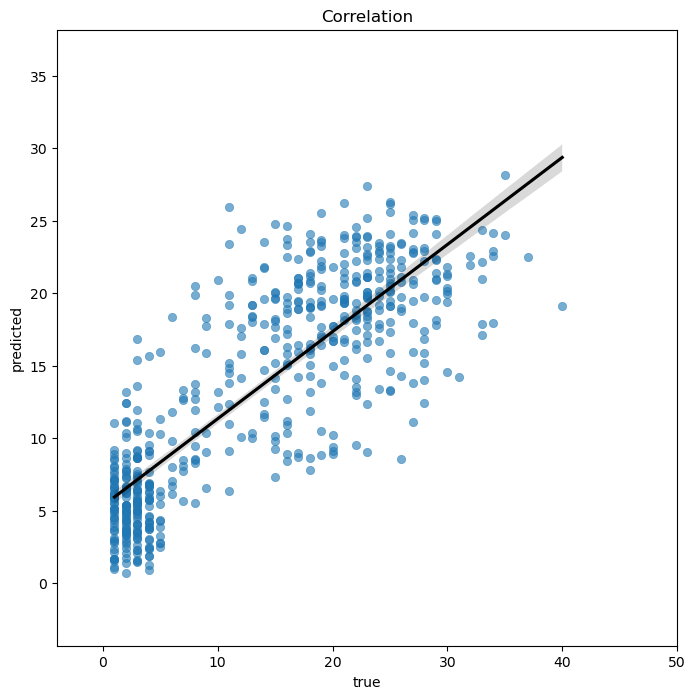

In [27]:
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# 假设已经计算并找到了最佳的 feature_selection_frequency 阈值
best_threshold = best_threshold

# 选择 feature_selection_frequency 大于等于最佳阈值的特征
selected_feature_mask = feature_selection_frequency >= best_threshold
X_selected = X.iloc[:, selected_feature_mask]

# 10 折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_list = []
r2_list = []
mae_list = []
pearson_corr_list = []
y_true_all = []  # 用于存储所有的真实值
y_pred_all = []  # 用于存储所有的预测值

for train_index, val_index in kf.split(X_selected):
    X_train_fold, X_val_fold = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # 使用 ElasticNet 模型进行训练
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio, random_state=42)
    elastic_net.fit(X_train_fold, y_train_fold)
    
    # 在验证集上预测
    y_pred_val = elastic_net.predict(X_val_fold)
    
    # 计算 MSE 和 R²
    mse = mean_squared_error(y_val_fold, y_pred_val)
    r2 = r2_score(y_val_fold, y_pred_val)
    mae = mean_absolute_error(y_val_fold, y_pred_val)
    pearson_corr, _ = pearsonr(y_val_fold, y_pred_val)
    
    # 将每次折叠的结果添加到列表中
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)
    pearson_corr_list.append(pearson_corr)
    
    # 存储当前折叠的真实值和预测值
    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred_val)

# 计算 10 折交叉验证的平均值
avg_mse = np.mean(mse_list)
avg_r2 = np.mean(r2_list)
avg_mae = np.mean(mae_list)
avg_pearson_corr = np.mean(pearson_corr_list)

# 输出最终的评估指标
print(f"\n基于最佳阈值 {best_threshold} 的评估结果：")
print(f"平均 R²: {avg_r2}")
print(f"平均 MAE: {avg_mae}")
print(f"平均 Pearson 相关系数: {avg_pearson_corr}")

# 绘制散点图
plt.figure(figsize=(8, 8))  # 设置图形为正方形
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, edgecolor=None)
sns.regplot(x=y_true_all, y=y_pred_all, scatter=False, color='black')

# 设置坐标轴范围
plt.xlim(min(y_true_all) - 5, max(y_true_all) + 10)
plt.ylim(min(y_pred_all) - 5, max(y_pred_all) + 10)

# 设置坐标轴标签和标题
plt.xlabel('true')
plt.ylabel('predicted')
plt.title('Correlation')

# 保存图形为 PDF 文件
# pdf_file_path = 'D:/代谢组/data/真实值与预测值散点图.pdf'
# plt.savefig(pdf_file_path, format='pdf')

# 显示图形
plt.show()


In [58]:
pip install YlGnOr

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement YlGnOr (from versions: none)
ERROR: No matching distribution found for YlGnOr



基于最佳阈值 0.97 的评估结果：
平均 R²: 0.6647388262362639
平均 MAE: 4.483143226983625
平均 Pearson 相关系数: 0.8267844032717356


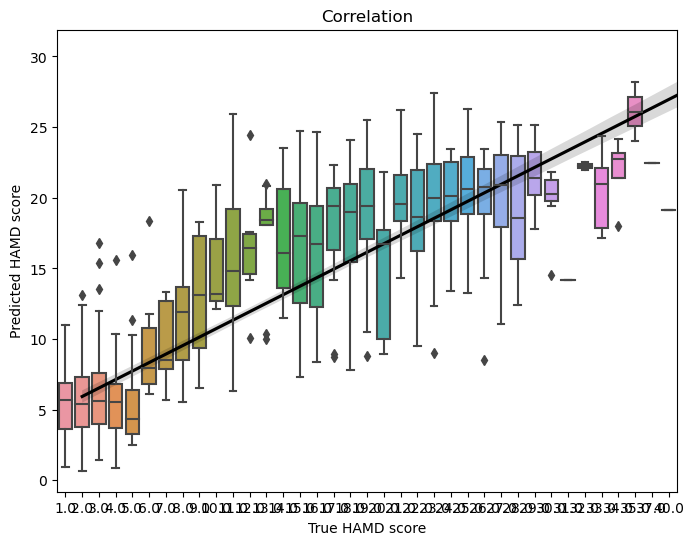

In [28]:
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# 假设已经计算并找到了最佳的 feature_selection_frequency 阈值
best_threshold = best_threshold

# 选择 feature_selection_frequency 大于等于最佳阈值的特征
selected_feature_mask = feature_selection_frequency >= best_threshold
X_selected = X.iloc[:, selected_feature_mask]

# 10 折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_list = []
r2_list = []
mae_list = []
pearson_corr_list = []
y_true_all = []  # 用于存储所有的真实值
y_pred_all = []  # 用于存储所有的预测值

for train_index, val_index in kf.split(X_selected):
    X_train_fold, X_val_fold = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # 使用 ElasticNet 模型进行训练
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio, random_state=42)
    elastic_net.fit(X_train_fold, y_train_fold)
    
    # 在验证集上预测
    y_pred_val = elastic_net.predict(X_val_fold)
    
    # 计算 MSE 和 R²
    mse = mean_squared_error(y_val_fold, y_pred_val)
    r2 = r2_score(y_val_fold, y_pred_val)
    mae = mean_absolute_error(y_val_fold, y_pred_val)
    pearson_corr, _ = pearsonr(y_val_fold, y_pred_val)
    
    # 将每次折叠的结果添加到列表中
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)
    pearson_corr_list.append(pearson_corr)
    
    # 存储当前折叠的真实值和预测值
    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred_val)

# 计算 10 折交叉验证的平均值
avg_mse = np.mean(mse_list)
avg_r2 = np.mean(r2_list)
avg_mae = np.mean(mae_list)
avg_pearson_corr = np.mean(pearson_corr_list)

# 输出最终的评估指标
print(f"\n基于最佳阈值 {best_threshold} 的评估结果：")
print(f"平均 R²: {avg_r2}")
print(f"平均 MAE: {avg_mae}")
print(f"平均 Pearson 相关系数: {avg_pearson_corr}")

# 将真实值和预测值转为DataFrame
df_predictions = pd.DataFrame({'True': y_true_all, 'Pred': y_pred_all})

# 绘制箱型图
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true_all, y=y_pred_all, scatter=False, color='black')
# 使用seaborn的boxplot绘制箱型图
sns.boxplot(x='True', y='Pred', data=df_predictions)

# 设置坐标轴标签和标题
plt.xlabel('True HAMD score')
plt.ylabel('Predicted HAMD score')
plt.title('Correlation')

# 显示图形
plt.show()



基于最佳阈值 0.97 的评估结果：
平均 R²: 0.6647388262362639
平均 MAE: 4.483143226983625
平均 Pearson 相关系数: 0.8267844032717356


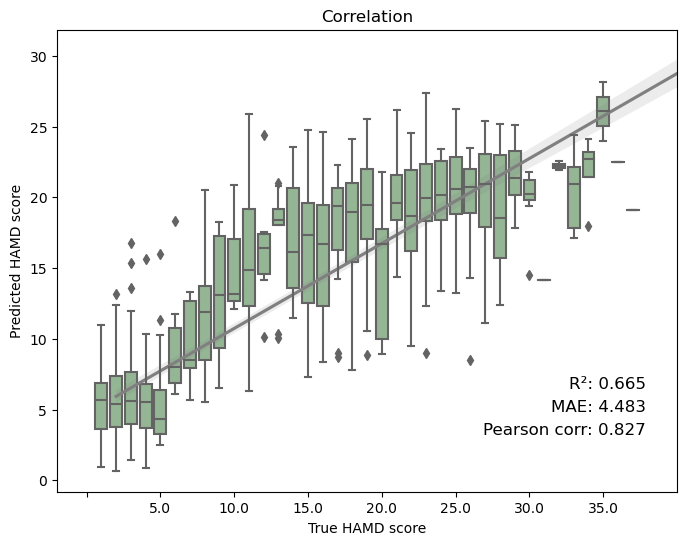

In [53]:
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib

# 假设已经计算并找到了最佳的 feature_selection_frequency 阈值
best_threshold = best_threshold

# 选择 feature_selection_frequency 大于等于最佳阈值的特征
selected_feature_mask = feature_selection_frequency >= best_threshold
X_selected = X.iloc[:, selected_feature_mask]

# 10 折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_list = []
r2_list = []
mae_list = []
pearson_corr_list = []
y_true_all = []  # 用于存储所有的真实值
y_pred_all = []  # 用于存储所有的预测值

for train_index, val_index in kf.split(X_selected):
    X_train_fold, X_val_fold = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # 使用 ElasticNet 模型进行训练
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio, random_state=42)
    elastic_net.fit(X_train_fold, y_train_fold)
    
    # 在验证集上预测
    y_pred_val = elastic_net.predict(X_val_fold)
    
    # 计算 MSE 和 R²
    mse = mean_squared_error(y_val_fold, y_pred_val)
    r2 = r2_score(y_val_fold, y_pred_val)
    mae = mean_absolute_error(y_val_fold, y_pred_val)
    pearson_corr, _ = pearsonr(y_val_fold, y_pred_val)
    
    # 将每次折叠的结果添加到列表中
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)
    pearson_corr_list.append(pearson_corr)
    
    # 存储当前折叠的真实值和预测值
    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred_val)

# 计算 10 折交叉验证的平均值
avg_mse = np.mean(mse_list)
avg_r2 = np.mean(r2_list)
avg_mae = np.mean(mae_list)
avg_pearson_corr = np.mean(pearson_corr_list)

# 输出最终的评估指标
print(f"\n基于最佳阈值 {best_threshold} 的评估结果：")
print(f"平均 R²: {avg_r2}")
print(f"平均 MAE: {avg_mae}")
print(f"平均 Pearson 相关系数: {avg_pearson_corr}")

# 将真实值和预测值转为DataFrame
df_predictions = pd.DataFrame({'True': y_true_all, 'Pred': y_pred_all})

# 创建自定义颜色映射：从草绿色到暗橙色
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "grass_to_orange", ["#8FBC8F", "#8FBC8F"], N=256
)

norm = Normalize(vmin=min(y_true_all), vmax=max(y_true_all))  # 规范化真实值

# 获取颜色
sm = ScalarMappable(cmap=cmap, norm=norm)
df_predictions['Color'] = df_predictions['True'].apply(lambda x: sm.to_rgba(x))

# 绘制箱型图
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true_all, y=y_pred_all, scatter=False, color='grey')

# 使用seaborn的boxplot绘制箱型图，并设置颜色
sns.boxplot(x='True', y='Pred', data=df_predictions, palette=df_predictions['Color'])

# 手动设置 x 轴刻度：从 -3 到最大值，步长为 5
x_ticks = np.arange(-1, 36, 5)

# 设置 x 轴的范围（稍微增加两边的空白）
plt.xlim(-3, 39)

# 设置 x 轴的刻度和标签
plt.xticks(x_ticks)

# 设置坐标轴标签和标题
plt.xlabel('True HAMD score')
plt.ylabel('Predicted HAMD score')
plt.title('Correlation')

# 添加评估指标文本（R², MAE, Pearson 相关系数）
plt.text(0.95, 0.25, f'R²: {avg_r2:.3f}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')
plt.text(0.95, 0.20, f'MAE: {avg_mae:.3f}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')
plt.text(0.95, 0.15, f'Pearson corr: {avg_pearson_corr:.3f}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')

# 显示图形
pdf_file_path = './all_correlation_distribution.pdf'
plt.savefig(pdf_file_path, format='pdf')
plt.show()


In [46]:
# 先不用管
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# 假设 X, y, 和 feature_selection_frequency 已经定义并准备好
# 选择 feature_selection_frequency >= 0.9 的特征
selected_feature_mask = feature_selection_frequency >= 0.9
X_selected = X.iloc[:, selected_feature_mask]

# 设置 10 折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 设置 ElasticNet 模型的超参数
best_alpha = 6.0  # 假设你已经选择了最优的 alpha 参数
best_l1_ratio = 0.01  # 假设你已经选择了最优的 l1_ratio 参数

# 初始化变量来存储模型
final_model = None

# 进行 10 折交叉验证，但只保留最后一次折叠的模型
for fold, (train_index, val_index) in enumerate(kf.split(X_selected)):
    X_train_fold, X_val_fold = X_selected.iloc[train_index], X_selected.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # 创建 ElasticNet 模型并进行训练
    model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
    model.fit(X_train_fold, y_train_fold)
    
    # 如果是最后一次折叠，保存模型
    if fold == 9:  # 最后一折，索引为 9
        final_model = model
        # 评估模型
        y_pred_val = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred_val)
        r2 = r2_score(y_val_fold, y_pred_val)
        print(f"Fold {fold + 1} - MSE: {mse}, R²: {r2}")

# 确保最终模型被训练
if final_model:
    # 在最后一折的训练集上进行评估
    y_pred = final_model.predict(X_val_fold)  # 使用最后一折的验证集进行预测
    final_mse = mean_squared_error(y_val_fold, y_pred)
    final_r2 = r2_score(y_val_fold, y_pred)

    # 输出评估结果
    print(f"最后一次折叠模型的 MSE: {final_mse}")
    print(f"最后一次折叠模型的 R²: {final_r2}")

    # 保存最后一次折叠的模型
    model_file_path = 'D:/adult_dep/12.28HAMD拟合/all_model.joblib'
    joblib.dump(final_model, model_file_path)
    print(f"模型已保存到 {model_file_path}")
else:
    print("没有训练出模型。")


Fold 10 - MSE: 55.81677376412975, R²: 0.6635709818201663
最后一次折叠模型的 MSE: 55.81677376412975
最后一次折叠模型的 R²: 0.6635709818201663
模型已保存到 D:/adult_dep/12.28HAMD拟合/all_model.joblib


In [13]:
# 读取特征名称
features_names = pd.read_csv('D:/代谢组/data/features_names.csv', header=None).iloc[0].tolist()

# 筛选特征
X_train_selected = X_train[features_names]
X_test_selected = X_test[features_names]

# 保存数据集
X_train_selected.to_csv('D:/代谢组/data/X_train_selected.csv', index=False)
X_test_selected.to_csv('D:/代谢组/data/X_test_selected.csv', index=False)

In [12]:
X_train_selected

,Gender,3.39_180.1142m/z,3.29_531.3505m/z,3.68_807.5687m/z,3.67_844.5250m/z,3.04_391.1409m/z,3.21_261.1285m/z,3.15_181.1214m/z,3.13_181.1161m/z,3.96_368.2789m/z,...,4.59_620.4528m/z,2.21_339.2393m/z,6.37_668.5632m/z,10.29_934.7343m/z,0.84_373.2700m/z,9.05_692.6952m/z,6.91_910.4997m/z,11.25_888.8598m/z,9.96_715.5764m/z,6.21_762.6052m/z
Sample_Name,,,,,,,,,,,,,,,,,,,,,
P69W44,1,0.265415,-0.952480,-0.640348,-0.241064,-0.785527,-0.221474,0.192546,0.359149,1.183155,...,0.955623,1.145268,0.156614,0.506124,1.436568,-2.583621,-0.470854,0.545409,0.112562,0.092669
P71W30,1,0.033176,0.553525,-0.001622,-0.374561,-0.395684,1.045648,0.609097,0.715081,0.318134,...,0.944015,-0.470444,1.015353,0.496014,0.600044,0.583137,-0.570205,0.246202,0.203106,0.138349
P62W25,1,-0.569850,0.272921,0.763271,1.231999,-0.500789,-0.014489,-0.928347,0.207370,1.049336,...,0.435458,0.720690,-0.343555,0.359994,0.609057,0.805037,0.983372,0.545409,0.598519,0.253184
P47W78,1,0.495730,-0.869229,0.241098,0.614050,-0.464794,-0.343845,-0.663283,0.867913,-0.815051,...,0.079428,0.244465,-0.244022,-0.493392,0.554210,-0.238443,0.479105,0.706941,-0.139690,-1.376982
P42W45,0,-0.227128,0.275093,0.535525,-0.032529,-0.282991,0.374516,0.753548,-2.002488,-1.403541,...,-1.199591,-1.654393,-0.554766,0.780107,-0.606940,-1.594502,0.338682,1.237343,0.353511,0.976835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P66W38,0,-1.033836,-1.775695,-0.884754,-0.782513,0.001747,1.058971,-0.600113,-0.136286,-0.626154,...,0.321712,1.091730,0.329510,-0.509622,-1.460237,0.417192,0.840735,0.331448,-0.250406,0.839158
P58W79,0,-0.809877,1.481368,-0.085339,0.503688,-0.635320,1.117594,-1.117824,-0.274579,-0.891139,...,0.688497,0.619166,-0.636695,-0.982233,1.747072,-0.534904,0.716496,0.046169,-0.231675,0.074150
P59W26,1,0.790029,-0.299382,0.672237,0.783122,-0.441344,0.720512,0.711322,0.801268,0.193971,...,0.079428,0.303446,0.030748,-0.192461,1.434774,0.020244,0.960063,0.406689,-6.150780,0.983197


d:\biosoft\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.376e+02, tolerance: 1.121e+01
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.191e+02, tolerance: 1.111e+01
  model = cd_fast.enet_coordinate_descent(
d:\biosoft\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e+02, tolerance: 1.123e+01
  

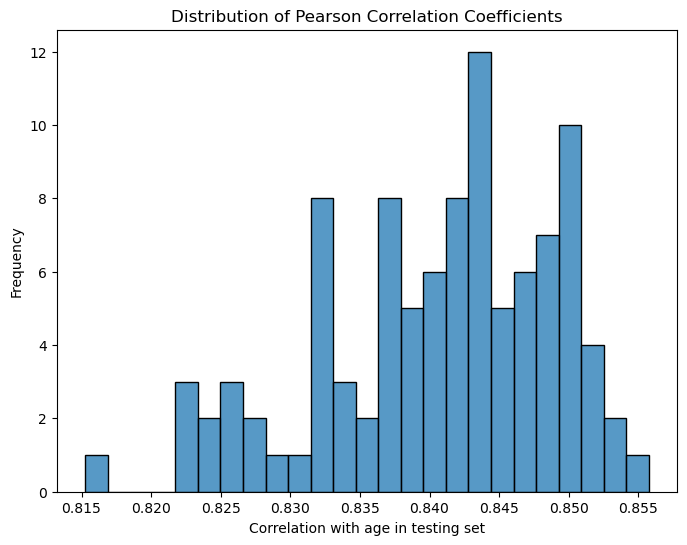

平均 MSE: 18.982602342810484
平均 R²: 0.7032287339791436


In [17]:
# 重复 100 次模型训练和评估
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score


# Bootstrap 重采样和模型评估
bootstrap_iterations = 100
correlations = []
mse_list = []
r2_list = []

for _ in range(bootstrap_iterations):
    bootstrap_indices = np.random.choice(range(X_train_selected.shape[0]), size=int(0.8 * X_train_array.shape[0]), replace=True)
    out_of_bag_indices = np.setdiff1d(range(X_train_selected.shape[0]), bootstrap_indices)
    
    X_train_bootstrap = X_train_selected[bootstrap_indices]
    y_train_bootstrap = y_train_array[bootstrap_indices]
    X_val_oob = X_train_selected[out_of_bag_indices]
    y_val_oob = y_train_array[out_of_bag_indices]
    
    elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=42)
    elastic_net.fit(X_train_bootstrap, y_train_bootstrap)
    
    y_pred_oob = elastic_net.predict(X_val_oob)
    mse = mean_squared_error(y_val_oob, y_pred_oob)
    r2 = r2_score(y_val_oob, y_pred_oob)
    corr = np.corrcoef(y_val_oob, y_pred_oob)[0, 1]
    
    mse_list.append(mse)
    r2_list.append(r2)
    correlations.append(corr)

# 提取相关性值
correlation_values = correlations

# 绘制 Pearson 相关系数分布直方图
plt.figure(figsize=(8, 6))
sns.histplot(correlation_values, bins=25, kde=False)
plt.xlabel('Correlation with age in testing set')
plt.ylabel('Frequency')
plt.title('Distribution of Pearson Correlation Coefficients')
pdf_file_path = 'D:/代谢组/data/correlation_distribution.pdf'
plt.savefig(pdf_file_path, format='pdf')
plt.show()

# 计算 MSE 和 R² 的平均值
avg_mse = np.mean(mse_list)
avg_r2 = np.mean(r2_list)

print(f"平均 MSE: {avg_mse}")
print(f"平均 R²: {avg_r2}")

In [20]:
# 构建最终模型（步骤3）
import joblib

final_model = ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=42)

final_model.fit(X_train_selected, y_train)

# 保存模型
model_file_path = 'D:/代谢组/data/elastic_net_model.joblib'
joblib.dump(final_model, model_file_path)
print(f"模型已保存到 {model_file_path}")

d:\biosoft\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+02, tolerance: 1.419e+01
  model = cd_fast.enet_coordinate_descent(


模型已保存到 D:/代谢组/data/elastic_net_model.joblib


In [21]:
import joblib

# 加载模型
model_file_path = 'D:/代谢组/data/elastic_net_model.joblib'
final_model = joblib.load(model_file_path)

X_test_selected = pd.read_csv('D:/代谢组/data/X_test_selected.csv')
# 使用加载的模型进行预测
y_pred_test = final_model.predict(X_test_selected)

d:\biosoft\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


In [22]:
X_test_selected

,Gender,3.39_180.1142m/z,3.29_531.3505m/z,3.68_807.5687m/z,3.67_844.5250m/z,3.04_391.1409m/z,3.21_261.1285m/z,3.15_181.1214m/z,3.13_181.1161m/z,3.96_368.2789m/z,...,4.59_620.4528m/z,2.21_339.2393m/z,6.37_668.5632m/z,10.29_934.7343m/z,0.84_373.2700m/z,9.05_692.6952m/z,6.91_910.4997m/z,11.25_888.8598m/z,9.96_715.5764m/z,6.21_762.6052m/z
0,1,-0.053117,0.353941,-0.765479,-0.160972,-0.550399,0.048972,-0.605252,0.187414,-0.177715,...,0.449358,-0.174835,0.156614,-0.961965,-0.051952,-1.294500,-1.040031,-1.139616,0.211207,-0.803301
1,1,-0.827438,-0.305073,0.016515,0.320015,-0.252521,-0.001595,-0.290029,-1.487568,-0.248547,...,0.449358,-0.005594,-1.649743,-1.169482,1.847391,0.120925,1.163642,-0.572292,0.298946,0.899137
2,1,0.517661,-0.007691,-0.047697,-0.105457,0.733628,-0.455737,0.711322,-0.120047,-2.679080,...,0.813068,0.346833,-1.247580,-1.421997,-0.685257,0.953307,0.280631,-0.013071,-0.059179,-0.363273
3,0,-0.003418,0.936236,-0.674090,-0.233592,0.960245,-0.135452,-0.015158,0.414259,0.404923,...,0.079428,3.510150,-0.101487,-0.961965,-1.111456,1.894499,1.074852,1.598329,0.858512,2.768990
4,1,0.346072,-1.146243,-1.246588,-0.597186,0.506806,0.191766,0.332409,-2.884246,0.188566,...,-1.174792,0.361138,1.282720,1.038424,-0.562954,0.719307,0.251182,1.507028,0.407130,1.045905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,1,-0.329045,-0.407197,-0.246871,-0.358183,-0.748145,0.610335,0.221336,-0.067612,1.216179,...,-1.433203,0.877766,0.329510,0.735326,-0.188500,0.470197,-0.246355,-0.305405,1.863617,0.852617
551,1,-0.291590,3.838106,-0.615410,-0.587572,0.455653,-0.438785,-0.549898,-0.176948,0.508954,...,-1.101678,2.448614,-0.273486,-0.714748,0.090543,0.631262,0.395638,-0.488639,0.376605,-0.099321
552,1,0.752365,-0.055310,0.836415,1.049548,1.094212,0.977322,0.609097,0.524818,-1.081144,...,-0.517225,-0.140107,0.247190,0.214636,1.527198,0.417192,0.338682,0.157381,0.162278,1.125039
553,1,-2.112973,0.515073,0.796111,0.458827,-0.896352,-0.014489,-0.194895,-1.234417,0.593880,...,0.584713,0.632072,0.974824,0.434319,0.664995,1.296980,0.451538,0.997185,0.283178,0.756770


In [23]:
y_pred_test

array([35.33007016, 38.85650696, 36.94703086, 45.14313371, 41.33883724,
       30.97689905, 45.05039932, 46.82173646, 32.83542337, 40.95645867,
       38.6823075 , 42.62309702, 42.53376107, 38.8033729 , 40.08123157,
       26.43921454, 37.51877233, 51.7474163 , 43.19620188, 41.75348437,
       38.89848063, 35.46328091, 41.75613917, 49.26083277, 42.88099252,
       48.33514574, 40.17197363, 38.04983646, 50.86190319, 37.9738126 ,
       42.43293645, 39.63426607, 52.76553057, 33.15496218, 39.66178559,
       39.23248874, 55.48308591, 34.27397103, 44.84065479, 52.68170739,
       35.73526868, 58.36503016, 49.83909091, 35.08617857, 43.8107942 ,
       38.73365848, 36.51673148, 46.77999052, 44.50342495, 43.23594652,
       37.99917691, 45.86946592, 41.87914858, 43.09969168, 51.55481886,
       44.10879614, 45.24313161, 38.55443669, 46.54113429, 42.59215121,
       46.41182466, 32.13160416, 43.95343821, 43.50034361, 32.45537957,
       49.13031768, 47.41293499, 39.99023559, 40.71783525, 52.67

模型已从 D:/代谢组/data/elastic_net_model.joblib 加载
Pearson相关系数: 0.7866261622818429
平均绝对误差 (MAE): 3.8075844575374447


d:\biosoft\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+02, tolerance: 1.419e+01
  model = cd_fast.enet_coordinate_descent(


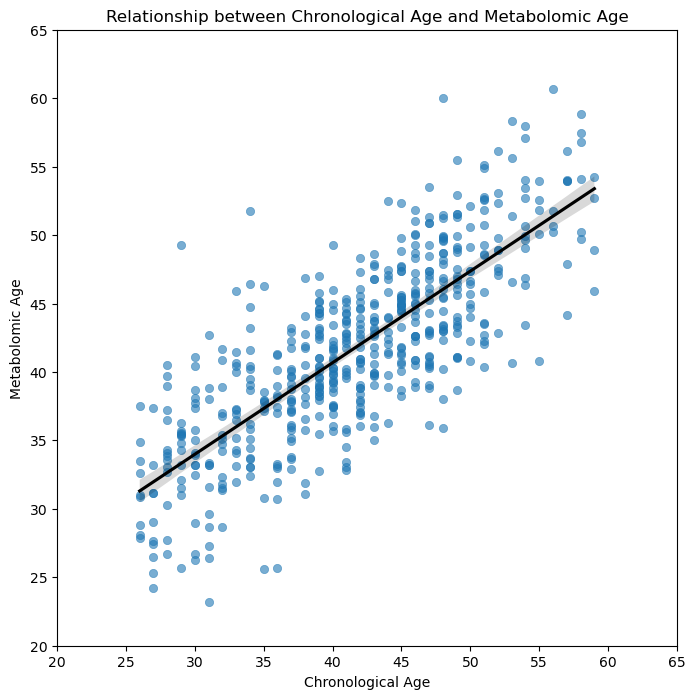

In [28]:

# 绘制代谢组学年龄与实际年龄的关系图
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


# 加载模型
model_file_path = 'D:/代谢组/data/elastic_net_model.joblib'
loaded_model = joblib.load(model_file_path)
print(f"模型已从 {model_file_path} 加载")

final_model.fit(X_train_selected, y_train)

# 使用训练好的模型对测试集进行预测
y_pred_test = final_model.predict(X_test_selected)

# 计算 Pearson 相关系数和平均绝对误差 (MAE)
pearson_corr, _ = pearsonr(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"Pearson相关系数: {pearson_corr}")
print(f"平均绝对误差 (MAE): {mae}")

# 绘制散点图
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.xlabel('Chronological Age')
# plt.ylabel('Metabolomic Age')
# plt.title('Relationship between Chronological Age and Metabolomic Age')
# plt.text(x=0.05, y=0.95, s=f'Pearson: {pearson_corr:.2f}\nMAE: {mae:.2f}\nR²: {r2:.2f}', 
#          ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# plt.grid(True)
# pdf_file_path = 'D:/代谢组/data/线性关系图.pdf'
# plt.savefig(pdf_file_path, format='pdf')
# plt.show()



# # 绘制散点图
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, edgecolor=None)
# sns.regplot(x=y_test, y=y_pred_test, scatter=False, color='black')
# plt.xlabel('Chronological Age')
# plt.ylabel('Metabolomic Age')
# plt.title('Relationship between Chronological Age and Metabolomic Age')
# pdf_file_path = 'D:/代谢组/data/线性关系图2.pdf'
# plt.savefig(pdf_file_path, format='pdf')
# plt.show()



# 绘制散点图
plt.figure(figsize=(8, 8))  # 设置图形为正方形
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, edgecolor=None)
sns.regplot(x=y_test, y=y_pred_test, scatter=False, color='black')
# 设置坐标轴范围
plt.xlim(20, 65)
plt.ylim(20, 65)
# 设置坐标轴标签和标题
plt.xlabel('Chronological Age')
plt.ylabel('Metabolomic Age')
plt.title('Relationship between Chronological Age and Metabolomic Age')
# 保存图形为 PDF 文件
pdf_file_path = 'D:/代谢组/data/线性关系图_new.pdf'
plt.savefig(pdf_file_path, format='pdf')
# 显示图形
plt.show()

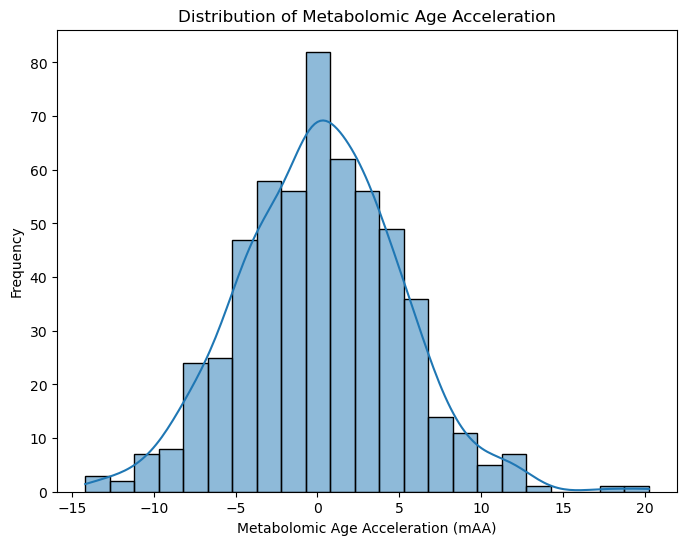

生物学年龄和生物学年龄加速结果已保存到 D:/代谢组/data/mAA_results.csv


In [22]:
# 计算生物学年龄和生物学年龄加速（mAA）
# y_pred_test = final_model.predict(X_test_selected)
mAA = y_pred_test - y_test

# 绘制生物学年龄加速的分布直方图
plt.figure(figsize=(8, 6))
sns.histplot(mAA, kde=True)
plt.xlabel('Metabolomic Age Acceleration (mAA)')
plt.ylabel('Frequency')
plt.title('Distribution of Metabolomic Age Acceleration')
pdf_file_path = 'D:/代谢组/data/mAA_result.pdf'
plt.savefig(pdf_file_path, format='pdf')
plt.show()

# 保存生物学年龄和生物学年龄加速数据
df_mAA = pd.DataFrame({
    'Chronological Age': y_test,
    'Metabolomic Age': y_pred_test,
    'Metabolomic Age Acceleration (mAA)': mAA
})

csv_file_path_mAA = 'D:/代谢组/data/mAA_results.csv'
df_mAA.to_csv(csv_file_path_mAA, index=False)
print(f"生物学年龄和生物学年龄加速结果已保存到 {csv_file_path_mAA}")